In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "xtick.direction": "in", "ytick.direction": "in"})

from scipy.constants import c as C

In [2]:
def gaussian(x, center, FWHM, normalisation_coeffient = None):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    if normalisation_coeffient == None:
        normalisation_coeffient = 0.5/np.sum(np.abs(np.exp(exponent))) #1 /(sigma *(2*np.pi)**0.5)
        return normalisation_coeffient *np.exp(exponent), normalisation_coeffient
    else:
        return normalisation_coeffient *np.exp(exponent)

def validate_frequencies(array): # IF THE SHAPE IS EVEN THEN THE HIGHEST FREQUENCY LOSES PHASE INFOMATION!
    shape = array.shape

    valid_frequencies = []
    for dimention in shape:
        corrupted_frequency = False if dimention % 2 else -dimention//2
        valid_frequency = np.full(dimention, True, dtype=bool)
        valid_frequency[corrupted_frequency] = False
        valid_frequencies += [valid_frequency]
    
    validity_mask = np.ix_(*valid_frequencies) # openai suggested this one. literally no idea what np.ix_ is supposed to do.
    return validity_mask

def convolve(array, convol): # Convolves two arrays. Uses the fft which requires xs to be evenly spaced. Fast and works with nd.
    assert array.shape == convol.shape, "Arrays to convolve must be the same shape"

    convol = np.fft.ifftshift(convol) # THE RESPONCE FUNCTION SHOULD BE CENTERED ABOUT THE MIDDLE! Recenter it around 0 in order to remove any unwanted phase.
    convol_FT = np.fft.fftn(convol, norm= "backward")
    FT = np.fft.fftn(array, norm= "backward")

    validity_mask = validate_frequencies(array)
    convolved_FT = np.copy(FT)
    convolved_FT[validity_mask] = convol_FT[validity_mask] *FT[validity_mask]

    convolved = np.fft.irfftn(convolved_FT, norm= "backward", s= array.shape)
    return convolved

def deconvolve(array, deconvol): # Convolves two arrays. Uses the fft which requires xs to be evenly spaced. Fast and works with nd.
    assert array.shape == deconvol.shape, "Arrays to convolve must be the same shape"

    deconvol = np.fft.ifftshift(deconvol) # THE RESPONCE FUNCTION SHOULD BE CENTERED ABOUT THE MIDDLE! Recenter it around 0 in order to remove any unwanted phase.
    deconvol_FT = np.fft.fftn(deconvol, norm= "backward")
    FT = np.fft.fftn(array, norm= "backward")

    validity_mask = validate_frequencies(array)
    deconvolved_FT = np.copy(FT)
    deconvolved_FT[validity_mask] = FT[validity_mask] /deconvol_FT[validity_mask]

    deconvolved = np.fft.irfftn(deconvolved_FT, norm= "backward", s= array.shape)
    return deconvolved

In [3]:
array_length = 100 #in pixels
array_height = 75 #in pixels
pixel_pitch = 200 #in um. Assume that the pixels are square
central_freq = 3 #in THz
FWHM_freq = 3 #in THz
theta = 30 #in arcminutes
number_of_averages = 30 #Frames can be averaged to reduce noise during pre or post-processing. Will allow us to measure the variance.

In [4]:
central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /C #periodicity of the fringes as it appears on the camera in m^-1
FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /C # in m^-1

print(1/central_wavenumber/(pixel_pitch*1e-6)) # effective wavelength in pixels


28.628434317362835


In [5]:
####### CREATE GAUSSIAN FREQUENCIES ###########

wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
freqs = C *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
amplitudes, normalisation_coeffient = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)

In [6]:
####### ADD NOISE DUE TO VIBRATIONS ########
vibration_uncertainty = 0 #mm. uncertainty of the position of the peak due to vibrations.

temporal_sigma = vibration_uncertainty*1e-3 *2*np.sin(np.deg2rad(theta/60)) /C # convert to s.
noise = np.random.normal(0, temporal_sigma, number_of_averages)

vibration_amplitudes = np.repeat(amplitudes[None, :], number_of_averages, axis= 0)
vibration_amplitudes = (vibration_amplitudes *np.exp(1j *freqs[None, :]*1e12 *noise[:, None]))

In [7]:
######### MAKE 2D ############
intensity = np.fft.irfft(amplitudes, norm= "forward", n= array_length)
intensity = np.resize(intensity, (array_height, array_length))

vibration_intensity = np.fft.irfft(vibration_amplitudes, norm= "forward", axis= -1, n= array_length)

vibration_intensity = np.repeat(vibration_intensity[:, None, :], array_height, axis= 1)

vibration_intensity.shape

(30, 75, 100)

In [8]:
####### ADD READ NOISE ########
read_noise_sigma = 0.5

noise = np.random.normal(0, read_noise_sigma, (number_of_averages, array_height, array_length))
noisy_intensity = vibration_intensity +noise # BE CAREFUL WITH THIS! Intensity is being broadcasted to a new shape.

noisy_intensity.shape

(30, 75, 100)

In [9]:
########## 'TEMPORAL' AVERAGE ############

uncertainty = np.std(noisy_intensity, axis= 0)
averaged_intensity = np.mean(noisy_intensity, axis= 0)

averaged_intensity.shape

(75, 100)

In [10]:
########## SHIFT ALL INTERFEROGRAMS AROUND 0 ############

half_length = pixel_pitch*1e-3* array_length /2
half_height = pixel_pitch*1e-3* array_height /2

intensity = np.fft.fftshift(intensity)
noisy_intensity = np.fft.fftshift(noisy_intensity, axes= -1)
averaged_intensity = np.fft.fftshift(averaged_intensity)
uncertainty = np.fft.fftshift(uncertainty)


In [11]:
rows = np.arange(array_height)

mask0 = rows < array_height/3
mask2 = rows > 2*array_height/3
mask1 = ~np.logical_or(mask0, mask2)

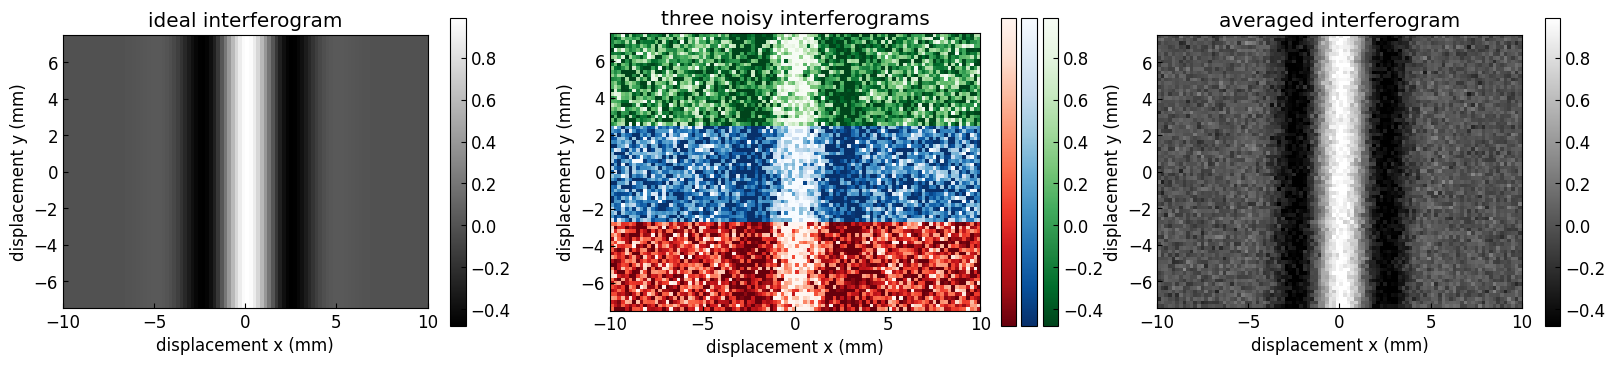

In [12]:
########### 2D IMAGES #############

extent = (-half_length, half_length, -half_height, half_height)

fig, axs = plt.subplots(1, 3, figsize= (20, 4))
axs = axs.flatten()

im0 = axs[0].imshow(intensity, extent= extent, cmap= "gray")
vmin, vmax = im0.get_clim()
fig.colorbar(im0)
axs[0].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "ideal interferogram")

im2a = axs[1].imshow(np.where(mask0[:, None], noisy_intensity[0], np.nan), extent= extent, cmap= "Greens_r", alpha= 1, vmin= vmin, vmax= vmax)
im2b = axs[1].imshow(np.where(mask1[:, None], noisy_intensity[1], np.nan), extent= extent, cmap= "Blues_r", alpha= 1, vmin= vmin, vmax= vmax)
im2c = axs[1].imshow(np.where(mask2[:, None], noisy_intensity[2], np.nan), extent= extent, cmap= "Reds_r", alpha= 1, vmin= vmin, vmax= vmax)

fig.colorbar(im2a, fraction= 0.05, pad= 0)
fig.colorbar(im2b, fraction= 0.05, pad= 0, ticks= [])
fig.colorbar(im2c, fraction= 0.05, ticks= [])
axs[1].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "three noisy interferograms")

im1 = axs[2].imshow(averaged_intensity, extent= extent, cmap= "gray", vmin= vmin, vmax= vmax)
fig.colorbar(im1)
axs[2].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "averaged interferogram")

#im3 = axs[3].imshow(uncertainty, extent= extent, cmap= "autumn_r")
#fig.colorbar(im3)
#axs[3].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "uncertainty in averaged interferogram")

plt.show()

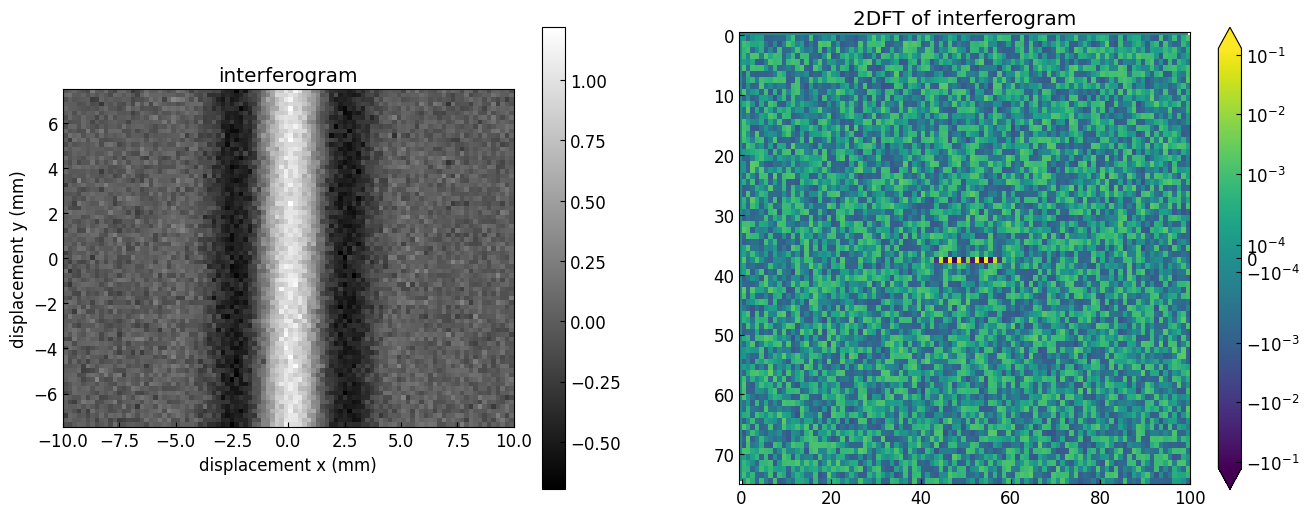

In [13]:
to_plot = np.real(np.fft.fftshift(np.fft.fftn(averaged_intensity, norm= "forward")))

fig, axs = plt.subplots(1, 2, figsize= (16, 6))

im0 = axs[0].imshow(averaged_intensity, extent= extent, interpolation= "none", cmap= "gray")
axs[0].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "interferogram")
fig.colorbar(im0)

im1 = axs[1].imshow(to_plot, interpolation= "none", aspect= to_plot.shape[1]/to_plot.shape[0])
axs[1].set(title= "2DFT of interferogram")

import matplotlib.colors as mplcolors
pcm = axs[1].pcolormesh(to_plot, norm=mplcolors.SymLogNorm(linthresh=5e-4, base=10), shading='auto')
fig.colorbar(pcm, ax=axs[1], extend='both')

plt.show()

### CONVOLUTION WITH RESPONSE FUNCTION

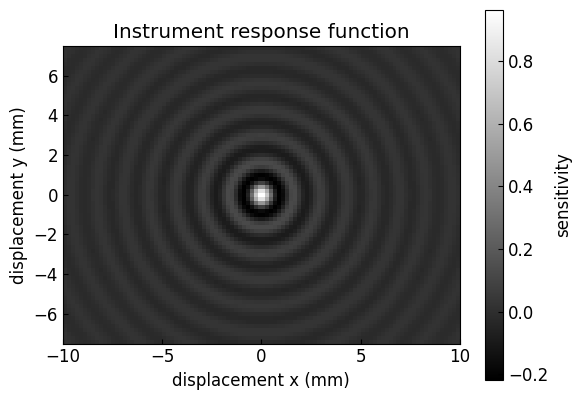

In [14]:
responsive_diameter = 1.34 #mm

y, x = np.mgrid[-half_height:half_height:array_height*1j, -half_length:half_length:array_length*1j]

r = np.sqrt(x**2 + y**2)


#response_function = np.float64(2*r <= responsive_diameter) #detect the sum of the values.
response_function = np.sinc(r/(responsive_diameter/2))


plt.imshow(response_function, extent= extent, interpolation= "nearest", cmap= "gray")
plt.xlabel("displacement x (mm)")
plt.ylabel("displacement y (mm)")
plt.title("Instrument response function")

cbar = plt.colorbar()
cbar.set_label('sensitivity')
plt.show()

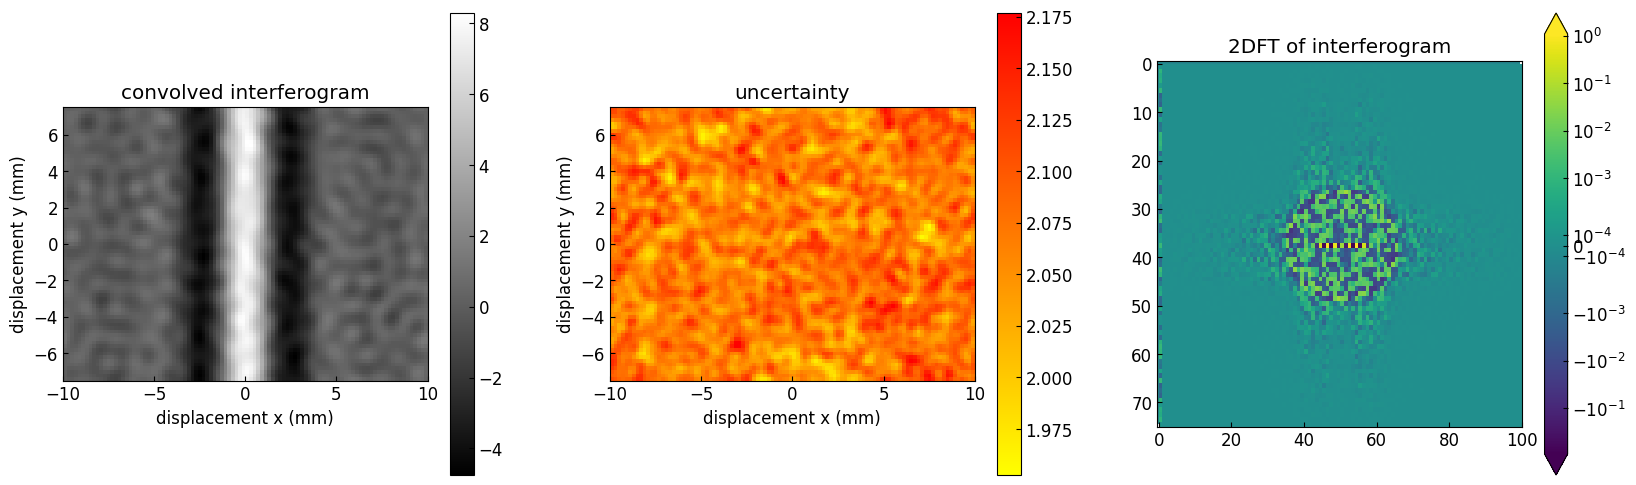

In [15]:
convolved_interferogram = convolve(averaged_intensity, response_function)
convolved_uncertainty = np.sqrt(convolve(uncertainty**2, response_function**2))

convolved_interferogram = np.real(convolved_interferogram)
convolved_uncertainty = np.real(convolved_uncertainty)

to_plot = np.real(np.fft.fftshift(np.fft.fftn(convolved_interferogram, norm= "forward")))

fig, axs = plt.subplots(1, 3, figsize= (20, 6))

im0 = axs[0].imshow(convolved_interferogram, extent= extent, cmap= "gray")
axs[0].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "convolved interferogram")
fig.colorbar(im0)

im1 = axs[1].imshow(convolved_uncertainty, extent= extent, cmap= "autumn_r")
axs[1].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "uncertainty")
fig.colorbar(im1)

im2 = axs[2].imshow(to_plot, interpolation= "none", aspect= to_plot.shape[1]/to_plot.shape[0])
axs[2].set(title= "2DFT of interferogram")

import matplotlib.colors as mplcolors
pcm = axs[2].pcolormesh(to_plot, norm=mplcolors.SymLogNorm(linthresh=5e-4, base=10), shading='auto')
fig.colorbar(pcm, ax=axs[2], extend='both')

plt.show()

### DECONVOLVE

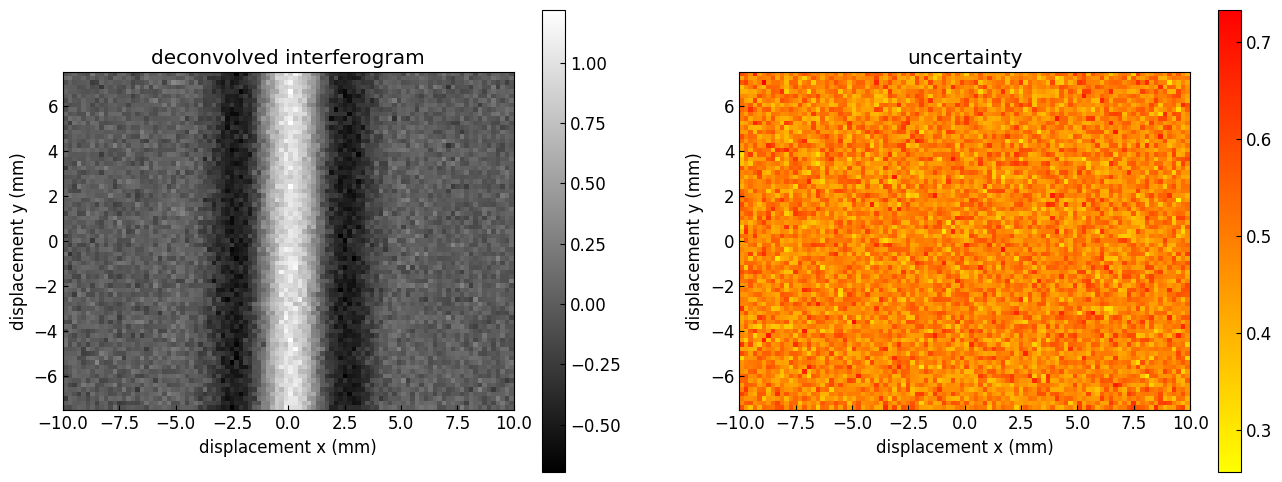

In [16]:
deconvolved_interferogram = deconvolve(convolved_interferogram, response_function)
deconvolved_uncertainty = np.sqrt(deconvolve(convolved_uncertainty**2, response_function**2))

deconvolved_interferogram = np.real(deconvolved_interferogram)
deconvolved_uncertainty = np.real(deconvolved_uncertainty)

fig, axs = plt.subplots(1, 2, figsize= (16, 6))

im0 = axs[0].imshow(deconvolved_interferogram, extent= extent, cmap= "gray")
axs[0].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "deconvolved interferogram")
fig.colorbar(im0)

im1 = axs[1].imshow(deconvolved_uncertainty, extent= extent, cmap= "autumn_r")
axs[1].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "uncertainty")
fig.colorbar(im1)

plt.show()

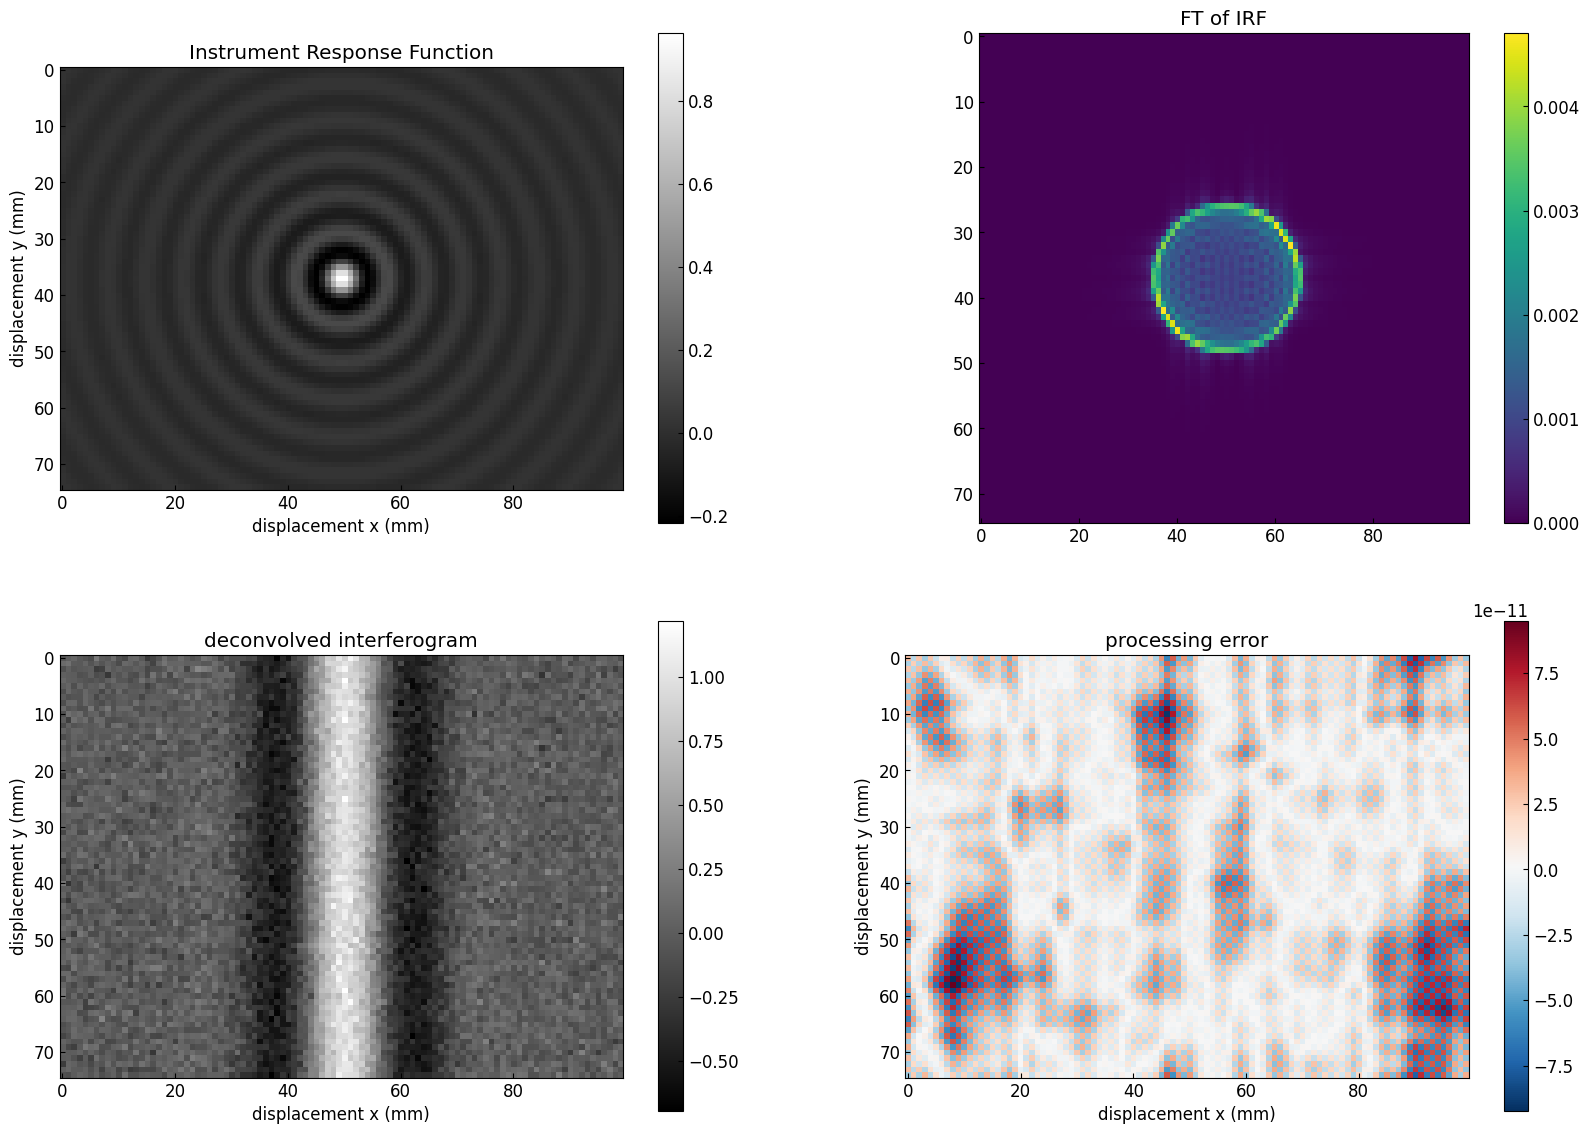

In [17]:
to_plot = np.real(np.fft.fftn(response_function, norm= "forward"))

#mask = validate_frequencies(to_plot)
#to_plot = to_plot[mask]

to_plot = np.fft.fftshift(to_plot)

fig, axs = plt.subplots(2, 2, figsize= (20, 14))
axs = axs.flatten()

im0 = axs[0].imshow(response_function, interpolation= "none", cmap= "gray")
axs[0].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "Instrument Response Function") # is this the same as the PSF?
fig.colorbar(im0)

im1 = axs[1].imshow(np.abs(to_plot), interpolation= "none", aspect= to_plot.shape[1]/to_plot.shape[0])
#import matplotlib.colors as mplcolors
#pcm = axs[1].pcolormesh(to_plot, norm=mplcolors.SymLogNorm(linthresh=1e-16, base=10), shading='auto') #<- prevents extent from working
axs[1].set(title= "FT of IRF")
fig.colorbar(im1)

im2 = axs[2].imshow(deconvolved_interferogram, interpolation= "none", cmap= "gray")
axs[2].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "deconvolved interferogram")
fig.colorbar(im2)

im3 = axs[3].imshow(averaged_intensity -deconvolved_interferogram, interpolation= "none", cmap= "RdBu_r")
axs[3].set(xlabel= "displacement x (mm)", ylabel= "displacement y (mm)", title= "processing error")
fig.colorbar(im3)

plt.show()

### SAVE FILE

In [18]:
file_number = 2

#np.savetxt("data\\2dmock{0:d}.csv".format(file_number), averaged_intensity, delimiter= ",")


from astropy.io import fits

interferogram_hdu = fits.PrimaryHDU(averaged_intensity)
error_hdu = fits.ImageHDU(uncertainty, name= "uncertainty")
convol_hdu = fits.ImageHDU(convolved_interferogram, name= "convolved")
convol_err_hdu = fits.ImageHDU(convolved_uncertainty, name= "convolved uncertainty")
IRF_hdu = fits.ImageHDU(response_function, name= "irf")

hdul = fits.HDUList([interferogram_hdu, error_hdu, convol_hdu, convol_err_hdu, IRF_hdu])

#hdul.writeto("data\\2dmock{0:d}.fits".format(file_number), overwrite= True) # OVERWRITE IS ENABLED!!!!!!!

In [19]:
### Try opening the file

hdul = fits.open("data\\2dmock{0:d}.fits".format(file_number))

interferogram_hdu = hdul["primary"] # or hdul[0]
error_hdu = hdul["uncertainty"] # or hdul[1]
convol_hdu = hdul["convolved"] # or hdul[2]
convol_err_hdu = hdul["convolved uncertainty"] # or hdul[3]
IRF_hdu = hdul["irf"] # or hdul[4] #THIS DOES NOT CREATE A COPY SO THE FILE MUST REMAIN OPEN.

interferogram = np.array(interferogram_hdu.data)
uncertainty = np.array(error_hdu.data)
convolved_interferogram = np.array(convol_hdu.data)
convolved_uncertainty = np.array(convol_err_hdu.data)
irf = np.array(IRF_hdu.data) #This does create a copy so we can close the file now :)

print(hdul.info())
hdul.close()

Filename: data\2dmock2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (100, 75)   float64   
  1  UNCERTAINTY    1 ImageHDU         8   (100, 75)   float64   
  2  CONVOLVED     1 ImageHDU         8   (100, 75)   float64   
  3  CONVOLVED UNCERTAINTY    1 ImageHDU         8   (100, 75)   float64   
  4  IRF           1 ImageHDU         8   (100, 75)   float64   
None
